## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)

2.154434690031884


In [4]:
parameter_names_1  = set(list(np.array(parameter_names).ravel()))
for p in parameter_names_1:
    print(p)

alpha
amplitude
beta


In [5]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 5.39 s, sys: 338 ms, total: 5.73 s
Wall time: 5.73 s


## Datasets

In [6]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


## Minos

In [7]:
        
numpoints = 20

In [8]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models[0])
    
    results = []
    for parname1 in parameter_names_1 :
        print( parname1)
        dataset.models.parameters[parname1].scan_n_values=numpoints
        result = fit_cor.stat_profile(dataset,
                             dataset.models.parameters[parname1],
                            reoptimize = True
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "fit_results":
                contour_write[k] = [float(_) for _ in result[k]]#.tolist()

        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [9]:
%%time
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 22.6 ms, sys: 0 ns, total: 22.6 ms
Wall time: 22.2 ms


In [10]:
%%time
computing = 0

if computing:
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


CPU times: user 100 ms, sys: 3.8 ms, total: 104 ms
Wall time: 103 ms


In [11]:
results_N

[{'Crablog.spectral.amplitude_scan': [2.993299156755616e-11,
   3.06561916023444e-11,
   3.139686460802287e-11,
   3.2155432742635065e-11,
   3.2932328363830173e-11,
   3.372799427529202e-11,
   3.454288397912192e-11,
   3.5377461934319145e-11,
   3.62322038215066e-11,
   3.710759681405229e-11,
   3.80041398557415e-11,
   3.8922343945156984e-11,
   3.986273242693128e-11,
   4.082584129003462e-11,
   4.1812219473270196e-11,
   4.282242917815039e-11,
   4.385704618933219e-11,
   4.491666020279459e-11,
   4.600187516194491e-11,
   4.711330960184572e-11],
  'stat_scan': [89146.04069156112,
   89144.87759458089,
   89143.85033424324,
   89142.95440388583,
   89142.18529562138,
   89141.53849674397,
   89141.00945897489,
   89140.59367435487,
   89140.2866387362,
   89140.08386369744,
   89139.98089174883,
   89139.97330000158,
   89140.05670908587,
   89140.22678925918,
   89140.47926685841,
   89140.80993284835,
   89141.21464767052,
   89141.68919754948,
   89142.22993968225,
   89142.832

KeyError: 'Crablog.spectral.alpha_scan'

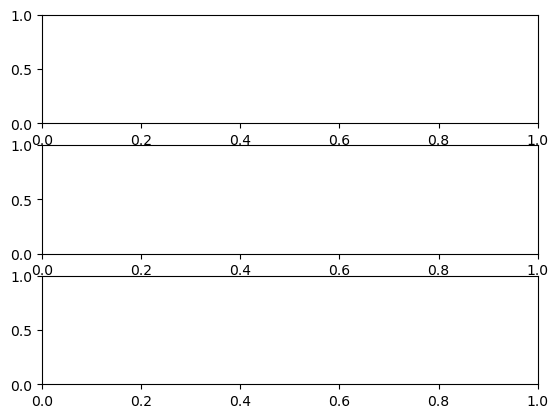

In [12]:
fig,axs = plt.subplots(3,1)
#axs = axs.flatten()
axs = axs.ravel()
for i, p in enumerate(parameter_names_1):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p}_scan']    
    b = results[i][f'stat_scan'] - np.min( results[i][f'stat_scan'])
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p].value,
                    y = 1,
                    xerr = dataset_asimov.models[0].parameters[p].error,
                    yerr = dataset_asimov.models[0].parameters[p].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p}_scan']    
    b = results_N[i][f'stat_scan'] - np.min( results_N[i][f'stat_scan'])
    axs[i].plot(a, b, color = aw[0])
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p].value,
                    y = 1,
                    xerr = dataset_asimov_N.models[0].parameters[p].error,
                    yerr = dataset_asimov_N.models[0].parameters[p].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p].value,
                    y = 1,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")